In [8]:
"""
    Setup Block # 1:
    SZ: edited Dec. 29, re-arranged
    This block contains definitions
"""

#@title Imports

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Polygon
from IPython.display import clear_output
import torch
import scipy
%matplotlib inline  

#@title Environment Code
import sys

EMPTY = 110
WALL = 111
START = 112
REWARD = 113
OUT_OF_BOUNDS = 114
LAVA = 118

TILES = {EMPTY, WALL, START, REWARD, LAVA}

STR_MAP = {
    'O': EMPTY,
    '#': WALL,
    'S': START,
    'R': REWARD,
    'L': LAVA
}

RENDER_DICT = {v:k for k, v in STR_MAP.items()}
RENDER_DICT[EMPTY] = ' '
RENDER_DICT[START] = ' '


def spec_from_string(s, valmap=STR_MAP):
    if s.endswith('\\'):
        s = s[:-1]
    rows = s.split('\\')
    rowlens = np.array([len(row) for row in rows])
    assert np.all(rowlens == rowlens[0])
    w, h = len(rows[0]), len(rows)

    gs = GridSpec(w, h)
    for i in range(h):
        for j in range(w):
            gs[j,i] = valmap[rows[i][j]]
    return gs


def spec_from_sparse_locations(w, h, tile_to_locs):
    """

    Example usage:
    >> spec_from_sparse_locations(10, 10, {START: [(0,0)], REWARD: [(7,8), (8,8)]})

    """
    gs = GridSpec(w, h)
    for tile_type in tile_to_locs:
        locs = np.array(tile_to_locs[tile_type])
        for i in range(locs.shape[0]):
            gs[tuple(locs[i])] = tile_type
    return gs


def local_spec(map, xpnt):
    """
    >>> local_spec("yOy\\\\Oxy", xpnt=(5,5))
    array([[4, 4],
           [6, 4],
           [6, 5]])
    """
    Y = 0; X=1; O=2
    valmap={
        'y': Y,
        'x': X,
        'O': O
    }
    gs = spec_from_string(map, valmap=valmap)
    ys = gs.find(Y)
    x = gs.find(X)
    result = ys-x + np.array(xpnt)
    return result


class GridSpec(object):
    def __init__(self, w, h):
        self.__data = np.zeros((w, h), dtype=np.int32)
        self.__w = w
        self.__h = h

    def __setitem__(self, key, val):
        self.__data[key] = val

    def __getitem__(self, key):
        if self.out_of_bounds(key):
            raise NotImplementedError("Out of bounds:"+str(key))
        return self.__data[tuple(key)]

    def out_of_bounds(self, wh):
        """ Return true if x, y is out of bounds """
        w, h = wh
        if w<0 or w>=self.__w:
            return True
        if h < 0 or h >= self.__h:
            return True
        return False

    def get_neighbors(self, k, xy=False):
        """ Return values of up, down, left, and right tiles """
        if not xy:
            k = self.idx_to_xy(k)
        offsets = [np.array([0,-1]), np.array([0,1]),
                   np.array([-1,0]), np.array([1,0])]
        neighbors = \
            [self[k+offset] if (not self.out_of_bounds(k+offset)) else OUT_OF_BOUNDS for offset in offsets ]
        return neighbors

    def get_value(self, k, xy=False):
        """ Return values of up, down, left, and right tiles """
        if not xy:
            k = self.idx_to_xy(k)
        return self[k]

    def find(self, value):
        return np.array(np.where(self.spec == value)).T

    @property
    def spec(self):
        return self.__data

    @property
    def width(self):
        return self.__w

    def __len__(self):
        return self.__w*self.__h

    @property
    def height(self):
        return self.__h

    def idx_to_xy(self, idx):
        if hasattr(idx, '__len__'):  # array
            x = idx % self.__w
            y = np.floor(idx/self.__w).astype(np.int32)
            xy = np.c_[x,y]
            return xy
        else:
            return np.array([ idx % self.__w, int(np.floor(idx/self.__w))])

    def xy_to_idx(self, key):
        shape = np.array(key).shape
        if len(shape) == 1:
            return key[0] + key[1]*self.__w
        elif len(shape) == 2:
            return key[:,0] + key[:,1]*self.__w
        else:
            raise NotImplementedError()

    def __hash__(self):
        data = (self.__w, self.__h) + tuple(self.__data.reshape([-1]).tolist())
        return hash(data)
 

ACT_NOOP = 0
ACT_UP = 1
ACT_DOWN = 2
ACT_LEFT = 3
ACT_RIGHT = 4
ACT_DICT = {
    ACT_NOOP: [0,0],
    ACT_UP: [0, -1],
    ACT_LEFT: [-1, 0],
    ACT_RIGHT: [+1, 0],
    ACT_DOWN: [0, +1]
}
ACT_TO_STR = {
    ACT_NOOP: 'NOOP',
    ACT_UP: 'UP',
    ACT_LEFT: 'LEFT',
    ACT_RIGHT: 'RIGHT',
    ACT_DOWN: 'DOWN'
}

class TransitionModel(object):
    def __init__(self, gridspec, eps=0.2):
        self.gs = gridspec
        self.eps = eps

    def get_aprobs(self, s, a):
        # TODO: could probably output a matrix over all states...
        legal_moves = self.__get_legal_moves(s)
        p = np.zeros(len(ACT_DICT))
        p[legal_moves] = self.eps / (len(legal_moves))
        if a in legal_moves:
            p[a] += 1.0-self.eps
        else:
            #p = np.array([1.0,0,0,0,0])  # NOOP
            p[ACT_NOOP] += 1.0-self.eps
        return p

    def __get_legal_moves(self, s):
        xy = np.array(self.gs.idx_to_xy(s))
        moves = [move for move in ACT_DICT if not self.gs.out_of_bounds(xy+ACT_DICT[move])
                                             and self.gs[xy+ACT_DICT[move]] != WALL]
        return moves

      
OBS_ONEHOT = 'onehot'
OBS_RANDOM = 'random'
OBS_SMOOTH = 'smooth'


class GridEnv(object):
    def __init__(self, gridspec, 
                 teps=0.0,
                 observation_type=OBS_ONEHOT,
                 dim_obs=8):
        super(GridEnv, self).__init__()
        self.num_states = len(gridspec)
        self.num_actions = 5
        self.obs_type = observation_type
        self.gs = gridspec
        self.model = TransitionModel(gridspec, eps=teps)
        self._transition_matrix = None
        self._transition_matrix = self.transition_matrix()

        if self.obs_type == OBS_RANDOM:
          self.dim_obs = dim_obs
          self.obs_matrix = np.random.randn(self.num_states, self.dim_obs)
        elif self.obs_type == OBS_SMOOTH:
          self.dim_obs = dim_obs
          self.obs_matrix = np.random.randn(self.num_states, self.dim_obs)
          trans_matrix = np.sum(self._transition_matrix, axis=1) / self.num_actions
          for k in range(10):
            cur_obs_mat = self.obs_matrix[:,:]
            for state in range(self.num_states):
                new_obs = trans_matrix[state].dot(cur_obs_mat)
                self.obs_matrix[state] = new_obs
        else:
          self.dim_obs = self.gs.width+self.gs.height

    def observation(self, s):
        if self.obs_type == OBS_ONEHOT:
          xy_vec = np.zeros(self.gs.width+self.gs.height)
          xy = self.gs.idx_to_xy(s)
          xy_vec[xy[0]] = 1.0
          xy_vec[xy[1]+self.gs.width] = 1.0
          return xy_vec
        elif self.obs_type == OBS_RANDOM or self.obs_type == OBS_SMOOTH:
          return self.obs_matrix[s]
        else:
          raise ValueError("Invalid obs type %s" % self.obs_type)
        
    def reward(self, s, a, ns):
        """ 
        Returns the reward (float)
        """
        tile_type = self.gs[self.gs.idx_to_xy(s)]
        if tile_type == REWARD:
          return 1
        elif tile_type == LAVA:
          return -1
        else:
          return 0

    def transitions(self, s, a):
        """
        Returns a dictionary of next_state (int) -> prob (float)
        """
        tile_type = self.gs[self.gs.idx_to_xy(s)]
        #if tile_type == LAVA: # Lava gets you stuck
        #    return {s: 1.0}
        if tile_type == WALL:
          return {s: 1.0}

        aprobs = self.model.get_aprobs(s, a)
        t_dict = {}
        for sa in range(5):
            if aprobs[sa] > 0:
                next_s = self.gs.idx_to_xy(s) + ACT_DICT[sa]
                next_s_idx = self.gs.xy_to_idx(next_s)
                t_dict[next_s_idx] = t_dict.get(next_s_idx, 0.0) + aprobs[sa]
        return t_dict
      
    def initial_state_distribution(self):
        start_idxs = np.array(np.where(self.gs.spec == START)).T
        num_starts = start_idxs.shape[0]
        initial_distribution = {}
        for i in range(num_starts):
          initial_distribution[self.gs.xy_to_idx(start_idxs[i])] = 1.0/num_starts 
        return initial_distribution

    def step_stateless(self, s, a, verbose=False):
        probs = self.transitions(s, a).items()
        ns_idx = np.random.choice(range(len(probs)), p=[p[1] for p in probs])
        ns = probs[ns_idx][0]
        rew = self.reward(s, a, ns)
        return ns, rew

    def step(self, a, verbose=False):
        ns, r = self.step_stateless(self.__state, a, verbose=verbose)
        self.__state = ns
        return ns, r, False, {}

    def reset(self):
        init_distr = self.initial_state_distribution().items()
        start_idx = np.random.choice(len(init_distr), p=[p[1] for p in init_distr])
        self.__state = init_distr[start_idx][0]
        self._timestep = 0
        return start_idx

    def render(self, close=False, ostream=sys.stdout):
        if close:
            return

        state = self.__state
        ostream.write('-'*(self.gs.width+2)+'\n')
        for h in range(self.gs.height):
            ostream.write('|')
            for w in range(self.gs.width):
                if self.gs.xy_to_idx((w,h)) == state:
                    ostream.write('*')
                else:
                    val = self.gs[w, h]
                    ostream.write(RENDER_DICT[val])
            ostream.write('|\n')
        ostream.write('-' * (self.gs.width + 2)+'\n')
        
    def transition_matrix(self):
        if self._transition_matrix is None:
          transition_matrix = np.zeros((self.num_states, self.num_actions, self.num_states))
          for s in range(self.num_states):
            for a in range(self.num_actions):
              for ns, prob in self.transitions(s, a).items():
                transition_matrix[s,a,ns] = prob
          self._transition_matrix = transition_matrix
        return self._transition_matrix
    
#@title Plotting Code
PLT_NOOP = np.array([[-0.1,0.1], [-0.1,-0.1], [0.1,-0.1], [0.1,0.1]])
PLT_UP = np.array([[0,0], [0.5,0.5], [-0.5,0.5]])
PLT_LEFT = np.array([[0,0], [-0.5,0.5], [-0.5,-0.5]])
PLT_RIGHT = np.array([[0,0], [0.5,0.5], [0.5,-0.5]])
PLT_DOWN = np.array([[0,0], [0.5,-0.5], [-0.5,-0.5]])

TXT_OFFSET_VAL = 0.3
TXT_CENTERING = np.array([-0.08, -0.05])
TXT_NOOP = np.array([0.0,0])+TXT_CENTERING
TXT_UP = np.array([0,TXT_OFFSET_VAL])+TXT_CENTERING
TXT_LEFT = np.array([-TXT_OFFSET_VAL,0])+TXT_CENTERING
TXT_RIGHT = np.array([TXT_OFFSET_VAL,0])+TXT_CENTERING
TXT_DOWN = np.array([0,-TXT_OFFSET_VAL])+TXT_CENTERING

ACT_OFFSETS = [
    [PLT_NOOP, TXT_NOOP],
    [PLT_UP, TXT_UP],
    [PLT_DOWN, TXT_DOWN],
    [PLT_LEFT, TXT_LEFT],
    [PLT_RIGHT, TXT_RIGHT]
]

PLOT_CMAP = cm.RdYlBu

def plot_sa_values(env, q_values, text_values=False, 
                   invert_y=True, update=False,
                   title=None):
  w = env.gs.width
  h = env.gs.height
  
  if update:
    clear_output(wait=True)
  plt.figure(figsize=(2*w, 2*h))
  ax = plt.gca()
  normalized_values = q_values
  normalized_values = normalized_values - np.min(normalized_values)
  normalized_values = normalized_values/np.max(normalized_values)
  for x, y in itertools.product(range(w), range(h)):
      state_idx = env.gs.xy_to_idx((x, y))
      if invert_y:
          y = h-y-1
      xy = np.array([x, y])
      xy3 = np.expand_dims(xy, axis=0)

      for a in range(4, -1, -1):
          val = normalized_values[state_idx,a]
          og_val = q_values[state_idx,a]
          patch_offset, txt_offset = ACT_OFFSETS[a]
          if text_values:
              xy_text = xy+txt_offset
              ax.text(xy_text[0], xy_text[1], '%.2f'%og_val, size='small')
          color = PLOT_CMAP(val)
          ax.add_patch(Polygon(xy3+patch_offset, True,
                                     color=color))
  ax.set_xticks(np.arange(-1, w+1, 1))
  ax.set_yticks(np.arange(-1, h+1, 1))
  plt.grid()
  if title:
    # SZ Dec. 28: added labelsize
    plt.title(title, fontdict={'fontsize': 36})
  plt.show()

def plot_s_values(env, v_values, text_values=True, 
                  invert_y=True, update=False,
                  title=None):
  w = env.gs.width
  h = env.gs.height
  if update:
    clear_output(wait=True)
  plt.figure(figsize=(2*w, 2*h))
  ax = plt.gca()
  normalized_values = v_values
  normalized_values = normalized_values - np.min(normalized_values)
  normalized_values = normalized_values/np.max(normalized_values)
  for x, y in itertools.product(range(w), range(h)):
      state_idx = env.gs.xy_to_idx((x, y))
      if invert_y:
          y = h-y-1
      xy = np.array([x, y])

      val = normalized_values[state_idx]
      og_val = v_values[state_idx]
      if text_values:
          xy_text = xy
          ax.text(xy_text[0], xy_text[1], '%.2f'%og_val, size='small')
      color = PLOT_CMAP(val)
      ax.add_patch(Rectangle(xy-0.5, 1, 1, color=color))
  ax.set_xticks(np.arange(-1, w+1, 1))
  ax.set_yticks(np.arange(-1, h+1, 1))
  plt.grid()  
  if title:
    plt.title(title)
  plt.show()
  
#@title Neural Network Code

def stack_observations(env):
    obs = []
    for s in range(env.num_states):
        obs.append(env.observation(s))
    return np.stack(obs)

class FCNetwork(torch.nn.Module):
  def __init__(self, env, layers=[20,20]):
    super(FCNetwork, self).__init__()
    self.all_observations = torch.tensor(stack_observations(env), dtype=torch.float32)
    dim_input = env.dim_obs
    dim_output = env.num_actions
    net_layers = []

    dim = dim_input
    for i, layer_size in enumerate(layers):
      net_layers.append(torch.nn.Linear(dim, layer_size))
      net_layers.append(torch.nn.ReLU())
      dim = layer_size
    net_layers.append(torch.nn.Linear(dim, dim_output))
    self.layers = net_layers
    self.network = torch.nn.Sequential(*net_layers)

  def forward(self, states):
    observations = torch.index_select(self.all_observations, 0, states) 
    return self.network(observations)
  

def one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return y_one_hot
  

class TabularNetwork(torch.nn.Module):
  def __init__(self, env):
    super(TabularNetwork, self).__init__()
    self.num_states = env.num_states
    self.network = torch.nn.Sequential(
        torch.nn.Linear(self.num_states, env.num_actions)
    )

  def forward(self, states):
    onehot = one_hot(states, self.num_states)
    return self.network(onehot)

#@title Utility Functions

def compute_policy_deterministic(q_values, eps_greedy=0.0):
  policy_probs = np.zeros_like(q_values)
  policy_probs[np.arange(policy_probs.shape[0]), np.argmax(q_values, axis=1)] = 1.0 - eps_greedy
  policy_probs += eps_greedy / (policy_probs.shape[1])
  return policy_probs

def compute_policy_stochastic(q_values, tau=1.0):
  q_values = q_values / tau
  
  if isinstance(q_values, torch.Tensor):
    softmax_fn = torch.nn.Softmax(dim=1)
  elif isinstance(q_values, np.ndarray):
    softmax_fn = scipy.special.softmax
  
  return softmax_fn(q_values)

def compute_visitation(env, policy, discount=1.0, T=50):
  dS = env.num_states
  dA = env.num_actions
  state_visitation = np.zeros((dS, 1))
  for (state, prob) in env.initial_state_distribution().items():
    state_visitation[state] = prob
  t_matrix = env.transition_matrix()  # S x A x S
  sa_visit_t = np.zeros((dS, dA, T))

  norm_factor = 0.0
  for i in range(T):
    sa_visit = state_visitation * policy
    cur_discount = (discount ** i)
    sa_visit_t[:, :, i] = cur_discount * sa_visit
    norm_factor += cur_discount
    # sum-out (SA)S
    new_state_visitation = np.einsum('ij,ijk->k', sa_visit, t_matrix)
    state_visitation = np.expand_dims(new_state_visitation, axis=1)
  return np.sum(sa_visit_t, axis=2) / norm_factor

"""
  Calculating KL between dist \pi_1(a|s) and dist \pi_2(a|s) of dimension S x A
  Distributions can be unnormalized (e.g exp(Q) is a valid distribution)
  KL calculated as E_{s \in S, a \sim \pi_1(a|s)}[log(\pi_1(a|s)/\pi_2(a|s))]
"""
def compute_divergence(dist1, dist2):
  norm_dist1 = dist1/(dist1.sum(-1, keepdims=True) + 1e-9)
  norm_dist2 = dist2/(dist2.sum(-1, keepdims=True) + 1e-9)
  summ = (norm_dist1 * np.log(norm_dist1/(norm_dist2 + 1e-9) + 1e-9)).sum(-1) # should be S
  return summ.mean()
  

def compute_return(env, policy, discount=1.0, T=50):
  dS = env.num_states
  dA = env.num_actions
  state_visitation = np.zeros((dS, 1))

  for (state, prob) in env.initial_state_distribution().items():
    state_visitation[state] = prob
  
  rewards = np.zeros((dS, 1))
  w = env.gs.width
  h = env.gs.height
  for x, y in itertools.product(range(w), range(h)):
    state = env.gs.xy_to_idx((x, y))
    state_xy = env.gs.idx_to_xy(state)
    tile = env.gs[state_xy]
    rewards[state] = -1 if tile == LAVA else rewards[state]
    rewards[state] = 1 if tile == REWARD else rewards[state]
  t_matrix = env.transition_matrix()  # S x A x S
  sa_visit_t = np.zeros((dS, dA, T))

  norm_factor = 0.0
  for i in range(T):
    sa_visit = state_visitation * policy
    cur_discount = (discount ** i)
    sa_visit_t[:, :, i] = cur_discount * sa_visit
    norm_factor += cur_discount
    # sum-out (SA)S
    new_state_visitation = np.einsum('ij,ijk->k', sa_visit, t_matrix)
    state_visitation = np.expand_dims(new_state_visitation, axis=1)
  
  vis = np.sum(sa_visit_t, axis=2) / norm_factor
  return (vis*rewards).sum() 

def get_tensors(list_of_tensors, list_of_indices):
  s, a, ns, r = [], [], [], []
  for idx in list_of_indices:
    s.append(list_of_tensors[idx][0])
    a.append(list_of_tensors[idx][1])
    r.append(list_of_tensors[idx][2])
    ns.append(list_of_tensors[idx][3])
  s = np.array(s)
  a = np.array(a)
  ns = np.array(ns)
  r = np.array(r)
  return s, a, ns, r


In [9]:


"""
    Setup Block # 2:
    SZ: edited Dec. 29, re-arranged
    This block contains different Q function updates
"""


#@title Tabular Q-iteration

def q_backup_sparse(env, q_values, discount=0.99):
  dS = env.num_states
  dA = env.num_actions
    
  new_q_values = np.zeros_like(q_values)
  value = np.max(q_values, axis=1)
  for s in range(dS):
    for a in range(dA):
      new_q_value = 0
      for ns, prob in env.transitions(s, a).items():
        new_q_value += prob * (env.reward(s,a,ns) + discount*value[ns])
      new_q_values[s,a] = new_q_value
  return new_q_values

def q_backup_sparse_sampled(env, q_values, s, a, ns, r, discount=0.99):
  q_values_ns = q_values[ns, :]
  values = np.max(q_values_ns, axis=-1)
  target_value = r + discount * values
  return target_value

def q_backup_sparse_policy(env, q_values, policy, discount=0.99):
  dS = env.num_states
  dA = env.num_actions
    
  new_q_values = np.zeros_like(q_values)
  value = np.sum(q_values * policy, axis=1)
  for s in range(dS):
    for a in range(dA):
      new_q_value = 0
      for ns, prob in env.transitions(s, a).items():
        new_q_value += prob * (env.reward(s,a,ns) + discount*value[ns])
      new_q_values[s,a] = new_q_value
  return new_q_values

def q_backup_sparse_sampled_policy(env, q_values, s, a, ns, r, policy, discount=0.99):
  q_values_ns = q_values[ns, :]
  policy_ns = policy[ns, :]
  values = np.sum(q_values_ns * policy_ns, axis=-1)
  target_value = r + discount * values
  return target_value

def q_iteration(env, num_itrs=100, render=False, **kwargs):
  """
  Run tabular Q-iteration
  
  Args:
    env: A GridEnv object
    num_itrs (int): Number of FQI iterations to run
    render (bool): If True, will plot q-values after each iteration
  """
  q_values = np.zeros((env.num_states, env.num_actions))
  for i in range(num_itrs):
    q_values = q_backup_sparse(env, q_values, **kwargs)
    if render:
      plot_sa_values(env, q_values, update=True, title='Q-values')
  return q_values

#@title Fitted Q-iteration

def project_qvalues(q_values, network, optimizer, num_steps=50, weights=None):
    # regress onto q_values (aka projection)
    q_values_tensor = torch.tensor(q_values, dtype=torch.float32)
    for _ in range(num_steps):
       # Eval the network at each state
      pred_qvalues = network(torch.arange(q_values.shape[0]))
      if weights is None:
        loss = torch.mean((pred_qvalues - q_values_tensor)**2)
      else:
        loss = torch.mean(weights*(pred_qvalues - q_values_tensor)**2)
      network.zero_grad()
      loss.backward()
      optimizer.step()
    return pred_qvalues.detach().numpy()

def project_qvalues_sampled(env, s, a, target_values, network, optimizer, num_steps=50, weights=None):
    # train with a sampled dataset
    target_qvalues = torch.tensor(target_values, dtype=torch.float32)
    s = torch.tensor(s, dtype=torch.int64)
    a = torch.tensor(a, dtype=torch.int64)
    pred_qvalues = network(s)
    pred_qvalues = pred_qvalues.gather(1, a.reshape(-1,1)).squeeze()
    loss = torch.mean((pred_qvalues - target_qvalues)**2)
    network.zero_grad()
    loss.backward()
    optimizer.step()
    
    pred_qvalues = network(torch.arange(env.num_states))
    return pred_qvalues.detach().numpy()

  
def fitted_q_iteration(
    env, 
    network,
    num_itrs=100, 
    project_steps=50,
    render=False,
    weights=None,
    sampled=False,
    training_dataset=None,
    optimal_policy=None,
    **kwargs
  ):
  """
  Runs Fitted Q-iteration.
  
  Args:
    env: A GridEnv object.
    num_itrs (int): Number of FQI iterations to run.
    project_steps (int): Number of gradient steps used for projection.
    render (bool): If True, will plot q-values after each iteration.
    sampled (bool): Whether to use sampled datasets for training or not.
    training_dataset (list): list of (s, a, r, ns) pairs
  """
  dS = env.num_states
  dA = env.num_actions
  
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
  weights_tensor = None
  if weights is not None:
    weights_tensor = torch.tensor(weights, dtype=torch.float32)
  
  q_values = np.zeros((dS, dA))
  kls = []
  evals = []
  for i in range(num_itrs):
    if sampled:
      for j in range(project_steps):
        training_idx = np.random.choice(np.arange(len(training_dataset)), size=128)
        s, a, ns, r = get_tensors(training_dataset, training_idx)
        target_values = q_backup_sparse_sampled(env, q_values, s, a, ns, r, **kwargs)
        intermed_values = project_qvalues_sampled(
            env, s, a, target_values, network, optimizer, weights=None,
        )
        if j == project_steps - 1:
          q_values = intermed_values
    else:                          
      target_values = q_backup_sparse(env, q_values, **kwargs)
      q_values = project_qvalues(target_values, network, optimizer,
                                weights=weights_tensor,
                                num_steps=project_steps)
    
    stochastic_policy = compute_policy_stochastic(q_values)
    if optimal_policy is not None:
      kl = compute_divergence(stochastic_policy, optimal_policy)
      kls.append(kl)
    policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
    ret = compute_return(env,policy, T=num_itrs)
    evals.append(ret)
    if render:
      plot_sa_values(env, q_values, update=True, title='Q-values Iteration %d' %i)
  
  plt.figure()
  plt.plot(kls)
  plt.title('KL Divergence from Optimal Policy')
  plt.show()

  plt.figure()
  plt.plot(evals)
  plt.title('Return of Trained Policy')
  plt.show()
  
  return q_values


def fitted_q_evaluation(
    env, 
    network,
    policy=None,
    num_itrs=100, 
    project_steps=50,
    render=False,
    weights=None,
    sampled=False,
    training_dataset=None,
    optimal_policy=None,
    **kwargs
  ):
  """
  Runs Fitted Q-evaluation.
  
  Args:
    env: A GridEnv object.
    num_itrs (int): Number of FQI iterations to run.
    project_steps (int): Number of gradient steps used for projection.
    render (bool): If True, will plot q-values after each iteration.
    sampled (bool): Whether to use sampled datasets for training or not.
    training_dataset (list): list of (s, a, r, ns) pairs
  """
  dS = env.num_states
  dA = env.num_actions
  
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
  weights_tensor = None
  if weights is not None:
    weights_tensor = torch.tensor(weights, dtype=torch.float32)
    assert weights_tensor.shape == (dS, dA)
    
  if policy is None:
    norm_factor = weights.sum(1).reshape(-1, 1)
    norm_factor = np.repeat(norm_factor, dA, axis=1)
    policy = weights/norm_factor
    assert policy.shape == (dS, dA)
    
  q_values = np.zeros((dS, dA))
  kls = []
  kls_target = []
  
  evals = []
  for i in range(num_itrs):
    if sampled:
      for j in range(project_steps):
        training_idx = np.random.choice(np.arange(len(training_dataset)), size=128)
        s, a, ns, r = get_tensors(training_dataset, training_idx)
        target_values = q_backup_sparse_sampled_policy(env, q_values, s, a, ns, r, policy, **kwargs)
        intermed_values = project_qvalues_sampled(
            env, s, a, target_values, network, optimizer, weights=None,
        )
        if j == project_steps - 1:
          q_values = intermed_values
    else:                          
      target_values = q_backup_sparse_policy(env, q_values, policy, **kwargs)
      q_values = project_qvalues(target_values, network, optimizer,
                                weights=weights_tensor,
                                num_steps=project_steps)
    
    stochastic_policy = compute_policy_stochastic(q_values)
    if optimal_policy is not None:
      kl = compute_divergence(stochastic_policy, optimal_policy)
      kls.append(kl)
    
    if policy is not None:
      kl_targ_policy = compute_divergence(stochastic_policy, policy)
      kls_target.append(kl_targ_policy)
      
    policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
    ret = compute_return(env,policy, T=num_itrs)
    evals.append(ret)
    if render:
      plot_sa_values(env, q_values, update=True, title='Q-values Iteration %d' %i)
  
  plt.figure()
  plt.plot(kls)
  plt.title('KL Divergence from Optimal Policy')
  plt.show()
  
  plt.figure()
  plt.plot(kls_target)
  plt.title('KL Divergence from Target Policy')
  plt.show()

  plt.figure()
  plt.plot(evals)
  plt.title('Return of Trained Policy')
  plt.show()
  
  return q_values

#@title Conservative Q-Learning

def get_fg(transform_type, const_val):
    def tanh_transform_fn(q_arr):
        return const_val * torch.tanh(q_arr/ (const_val + 1e-9)) 
    
    def exp_transform_fn(q_arr):
        return torch.exp(q_arr/ (const_val + 1e-9)) 

    def cent_xexp_transform_fn(q_arr):
        cent = q_arr.mean().detach()
        q_cent = (q_arr - cent) / (const_val + 1e-9)
        return  q_cent * torch.exp(q_cent)
    
    def norm_xexp_transform_fn(q_arr, return_weight=False):
        q_new = (q_arr/(const_val + 1e-9))
        q_new = q_new - q_new.max()
        weight = torch.exp(q_new)/(torch.exp(q_new).sum() + 1e-9)
        weight = weight.detach()
        
        if return_weight:
            return weight
        return  q_arr * weight

    def norm_neg_xexp_transform_fn(q_arr, return_weight=False):
        q_new = -(q_arr/(const_val + 1e-9))
        q_new = q_new - q_new.max()
        weight = torch.exp(q_new)/(torch.exp(q_new).sum() + 1e-9)
        weight = weight.detach()
        
        if return_weight:
            return weight
        return  q_arr * weight
    
    def neg_exp_transform_fn(q_arr):
        return const_val * -1 * torch.exp(-1*q_arr/ (const_val + 1e-9)) 
    
    def log_transform_fun(q_arr):
        return const_val * torch.log(q_arr/ (const_val + 1e-9)) 

    def sig_transform_fun(q_arr):
        return const_val * torch.sigmoid(q_arr/ (const_val + 1e-9)) 
    
    def identity(q_arr):
        return q_arr
    
    f,g = identity, identity
    if transform_type > 0:
        if transform_type == 1:
            f = g = neg_exp_transform_fn
        elif transform_type == 2:
            f = neg_exp_transform_fn
            g = identity
        elif transform_type == 3:
            f = g = log_transform_fun
        elif transform_type == 4:
            f = g = sig_transform_fun
        elif transform_type == 5:
            f = identity
            g = exp_transform_fn
        elif transform_type == 6:
            f = identity
            g = cent_xexp_transform_fn
        elif transform_type == 7:
            f = identity
            g = norm_xexp_transform_fn
        elif transform_type == 8:
            f = norm_xexp_transform_fn
            g = norm_xexp_transform_fn
        elif transform_type == 9:
            f = norm_neg_xexp_transform_fn
            g = norm_neg_xexp_transform_fn
        elif transform_type == 10:
            f = norm_xexp_transform_fn
            g = identity
        elif transform_type == 11:
            f = g = tanh_transform_fn
        elif transform_type == 12:
            f = g = exp_transform_fn
        else:
            assert False
    return f,g

def project_qvalues_cql(q_values, network, optimizer, num_steps=50, cql_alpha=0.1, weights=None, transform_type=0, const_transform=2):
    # regress onto q_values (aka projection)
    q_values_tensor = torch.tensor(q_values, dtype=torch.float32)
    for _ in range(num_steps):
       # Eval the network at each state
      pred_qvalues = network(torch.arange(q_values.shape[0]))
      if weights is None:
        loss = torch.mean((pred_qvalues - q_values_tensor)**2)
      else:
        loss = torch.mean(weights*(pred_qvalues - q_values_tensor)**2)

      # Add cql_loss
      # You can have two variants of this loss, one where data q-values
      # also maximized (CQL-v2), and one where only the large Q-values 
      # are pushed down (CQL-v1) as covered in the tutorial
      f,g = get_fg(transform_type, const_transform)
      cql_loss = torch.logsumexp(f(pred_qvalues), dim=-1, keepdim=True) - g(pred_qvalues)
      loss = loss + cql_alpha * torch.mean(weights * cql_loss)
      network.zero_grad()
      loss.backward()
      optimizer.step()
    return pred_qvalues.detach().numpy()

def project_qvalues_cql_sampled(env, s, a, target_values, network, optimizer, cql_alpha=0.1, num_steps=50, weights=None, transform_type=0, const_transform=2, mc_returns = None):
    # train with a sampled dataset
    target_qvalues = torch.tensor(target_values, dtype=torch.float32)
    s = torch.tensor(s, dtype=torch.int64)
    a = torch.tensor(a, dtype=torch.int64)    
    pred_qvalues = network(s)
    
    if mc_returns is None:
      pre_lse_q_values = pred_qvalues
    else:
      # mc return is |s| x |a|
      mc_returns = torch.from_numpy(mc_returns)
      assert s.shape == a.shape, f"{s.shape} != {a.shape}"
      mc_returns = mc_returns[s]
      assert mc_returns.shape == pred_qvalues.shape, f"{mc_returns.shape} != {pred_qvalues.shape}"
      mc_returns = mc_returns.detach()
      
      pre_lse_q_values = torch.maximum(pred_qvalues, mc_returns)

    # f,g = get_fg(transform_type, const_transform)
    identity = lambda x: x
    f, g = identity, identity
    
    ### SZ: 1.3 put back the MC here
    
    logsumexp_qvalues = torch.logsumexp(f(pre_lse_q_values), dim=-1)
    
    pred_qvalues = pred_qvalues.gather(1, a.reshape(-1,1)).squeeze()
    cql_loss = logsumexp_qvalues - g(pred_qvalues)
    
    loss = torch.mean((pred_qvalues - target_qvalues)**2)
    loss = loss + cql_alpha * torch.mean(cql_loss)

    network.zero_grad()
    loss.backward()
    optimizer.step()
    
    pred_qvalues = network(torch.arange(env.num_states))
    return pred_qvalues.detach().numpy()
  
def conservative_q_iteration(env, 
                             network,
                             num_itrs=100, 
                             project_steps=50,
                             cql_alpha=0.1,
                             render=False,
                             weights=None,
                             sampled=False,
                             transform_type=0,
                             const_transform=2,
                             training_dataset=None,
                             optimal_policy=None,
                             mc_returns=None,
                             **kwargs):
  """
  Runs Conservative Q-iteration.
  
  Args:
    env: A GridEnv object.
    num_itrs (int): Number of FQI iterations to run.
    project_steps (int): Number of gradient steps used for projection.
    cql_alpha (float): Value of weight on the CQL coefficient.
    render (bool): If True, will plot q-values after each iteration.
    sampled (bool): Whether to use sampled datasets for training or not.
    training_dataset (list): list of (s, a, r, ns) pairs
  """
  dS = env.num_states
  dA = env.num_actions
  
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
  weights_tensor = None
  if weights is not None:
    weights_tensor = torch.tensor(weights, dtype=torch.float32)
  
  q_values = np.zeros((dS, dA))
  assert mc_returns is None or mc_returns.shape == q_values.shape, f"mc_returns shape {mc_returns.shape} does not match q_values shape {q_values.shape}"
  
  kls = []
  evals = []
  for i in range(num_itrs):
    if sampled:
      for j in range(project_steps):
        training_idx = np.random.choice(np.arange(len(training_dataset)), size=128)
        s, a, ns, r = get_tensors(training_dataset, training_idx)
        target_values = q_backup_sparse_sampled(env, q_values, s, a, ns, r, **kwargs)
        
        intermed_values = project_qvalues_cql_sampled(
            env, s, a, target_values, network, optimizer, 
            cql_alpha=cql_alpha, weights=None, 
            transform_type=transform_type, const_transform=const_transform,
            mc_returns=mc_returns,
        )
        if j == project_steps - 1:
          q_values = intermed_values
    else:
      target_values = q_backup_sparse(env, q_values, **kwargs)
      q_values = project_qvalues_cql(target_values, network, optimizer,
                                weights=weights_tensor,
                                cql_alpha=cql_alpha,
                                num_steps=project_steps,
                                transform_type=transform_type, const_transform=const_transform)
    ### SZ: edited Dec 31: added mc_returns
    ### SZ: editied Jan 01: moved mc_returns to project_qvalues_cql_sampled
    stochastic_policy = compute_policy_stochastic(q_values)
    if optimal_policy is not None:
      kl = compute_divergence(stochastic_policy, optimal_policy)
      kls.append(kl)
    policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
    ret = compute_return(env,policy, T=num_itrs)
    evals.append(ret)
    if render:
      plot_sa_values(env, q_values, update=True, title='Q-values Iteration %d' %i)
  
  plt.figure()
  plt.plot(kls)
  plt.title('KL Divergence from Optimal Policy')
  plt.show()

  plt.figure()
  plt.plot(evals)
  plt.title('Return of Trained Policy')
  plt.show()
  return q_values

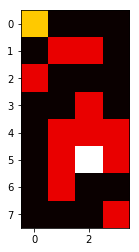

iters 1000
discount 0.95


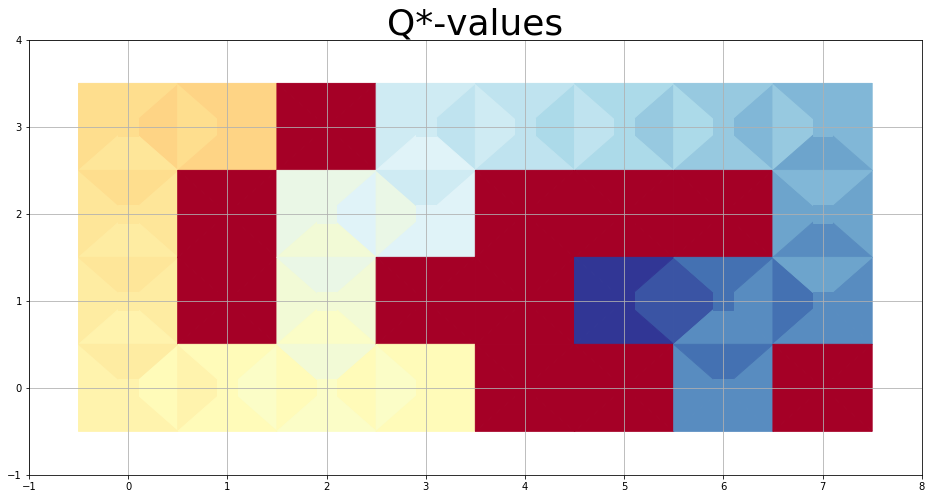

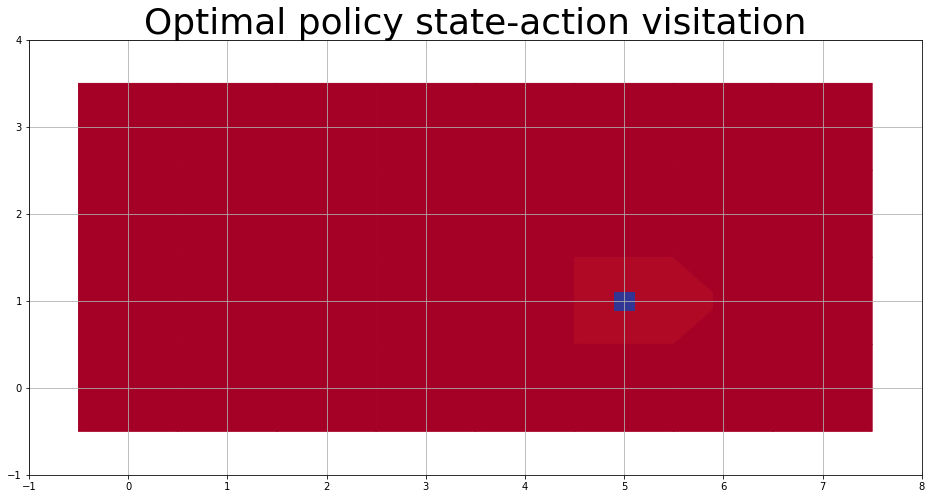

0.9593185301443299

In [10]:
"""
    Setup Block # 3:
    SZ: edited Dec. 29, re-arranged
    This block contains setup for parameters
"""

# @title Input Parameters

weighting_only = True #@param {type: "boolean"}
dataset_composition = 'random+optimal' #@param ["optimal", "random", "random+optimal", "mixed", 'mixed_limited', 'mixed_limited_skewed']
dataset_size =  5000#@param {type: "integer"}
env_type = 'smooth' #@param ["smooth", "random", "onehot"]

maze_type = 0

def valid_fn_default(x,y):
    return True # default valid function

def valid_fn_staged(x,y):
    return 0 <= x <= 3 or 7 <= x <= 11 or 15 <= x <= 19

valid_fn = valid_fn_default
if maze_type == 0:
    maze_str = (
        "SO#OOOOO\\"+
        "O#OO###O\\"+
        "O#O##ROO\\"+
        "OOOO##O#\\"
    )
elif maze_type == 1:
    maze_str = (
        "SOOOLLLL\\"+
        "OOOOLOOO\\"+
        "OOOOOOLO\\"+ 
        "OOOOLLLR\\"
    )
elif maze_type == 2:
    maze_str = (
        "SOOOLLLLOOOOLLLLOOOOLLLL\\"+
        "OOOOLOOOOOOOLOOOOOOOLOOO\\"+
        "OOOOOOLOOOOOOOLOOOOOOOLO\\"+
        "OOOOLLLOOOOOLLLOOOOOLLLR\\"
    )
    valid_fn = valid_fn_staged 
elif maze_type == 3:
    maze_str = (
        "SOOO####OOOO####OOOO####\\"+
        "OOOO#OOOOOOO#OOOOOOO#OOO\\"+
        "OOOOOO#OOOOOOO#OOOOOOO#O\\"+
        "OOOO###OOOOO###OOOOO###R\\"
    )
    valid_fn = valid_fn_staged
elif maze_type == 4:
    maze_str = (
        "########################\\"+
        "SOOO####OOOO####OOOO####\\"+
        "OOOO#OOOOOOO#OOOOOOO#OOO\\"+
        "OOOOOO#OOOOOOO#OOOOOOO#O\\"+
        "OOOO###OOOOO###OOOOO###O\\"+
        "#######################O\\"+
        "#OOR####OOOO####OOOO###O\\"+
        "#O###OOOOOOO#OOOOOOO#OOO\\"+
        "#OOOOO#OOOOOOO#OOOOOOO#O\\"+
        "#######OOOOO###OOOOO###O\\"
    )
    valid_fn = valid_fn_staged
elif maze_type == 5:
    maze_str = (
        "########################\\"+
        "SOOO####OOOO####OOOO####\\"+
        "OOOO#OOOOOOO#OOOOOOO#OOO\\"+
        "OOOOOO#OOOOOOO#OOOOOOO#O\\"+
        "OOOO###OOOOO###OOOOO###O\\"+
        "#######################O\\"+
        "OOOO####OOOO####OOOO###O\\"+
        "OOOO#OOOOOOO#OOOOOOO#OOO\\"+
        "OOOOOO#OOOOOOO#OOOOOOO#O\\"+
        "OOOO###OOOOO###OOOOO###O\\"+
        "OOOO####################\\"+
        "OOOO####OOOO####OOOO###O\\"+
        "OOOO#OOOOOOO#OOOOOOO#OOO\\"+
        "OOOOOO#OOOOOOO#OOOOOOO#O\\"+
        "OOOO###OOOOO###OOOOO###R\\"+
        "########################\\"
    )
    valid_fn = valid_fn_staged
elif maze_type == 6:
    maze_str = (
        "########################\\"+
        "SOOO#OOOOOOO####OOOO####\\"+
        "OOOO#O#OOOOO#OOOOOOO#OOO\\"+
        "OOOOOO##OOOOOO#OOOOOOO#O\\"+
        "OOOO#OO#OOOO###OOOOO###O\\"+
        "#######################O\\"+
        "OOOO#OOO#OOO####OOOO###O\\"+
        "OOOOOO#O#OOO#OOOOOOO#OOO\\"+
        "OOOO#O#O#OOOOO#OOOOOOO#O\\"+
        "OOOO#O#OOOOO###OOOOO###O\\"+
        "OOOO####################\\"+
        "OOOO####OOOO####OOOO###O\\"+
        "OOOO#OOOOOOO#OOOOOOO#OOO\\"+
        "OOOOOO#OOOOOOO#OOOOOOO#O\\"+
        "OOOO#O#OOOOO###OOOOO###R\\"+
        "########################\\"
    )
    valid_fn = valid_fn_staged
else:
    assert False

maze = spec_from_string(maze_str)

plt.figure()
plt.imshow(maze._GridSpec__data, cmap='hot', interpolation='nearest')
plt.show()

env = GridEnv(maze, observation_type=env_type, dim_obs=8)

if maze_type in list(range(0,4)):
    num_itrs=1000
    discount=0.95
elif maze_type in list(range(4,6)):    
    num_itrs=1000
    discount=0.98
else:
    num_itrs=1000
    discount=0.99
print('iters', num_itrs)
print('discount', discount)

optimal_qvalues = q_iteration(env, num_itrs=num_itrs, discount=discount, render=False)

plot_sa_values(env, optimal_qvalues, title='Q*-values')

optimal_policy = policy = compute_policy_deterministic(optimal_qvalues, eps_greedy=0.1)
sa_visitations = compute_visitation(env, policy, T=num_itrs)
plot_sa_values(env, sa_visitations, title='Optimal policy state-action visitation')

compute_return(env, optimal_policy, T=num_itrs)

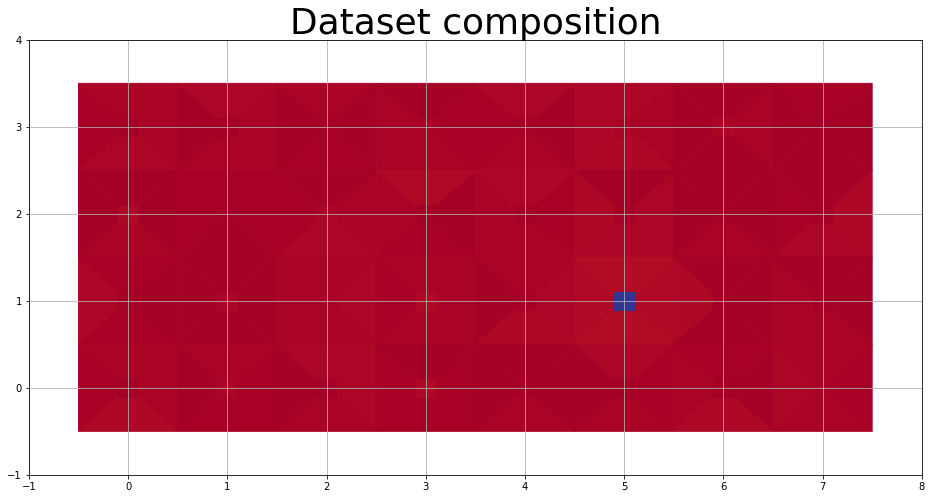

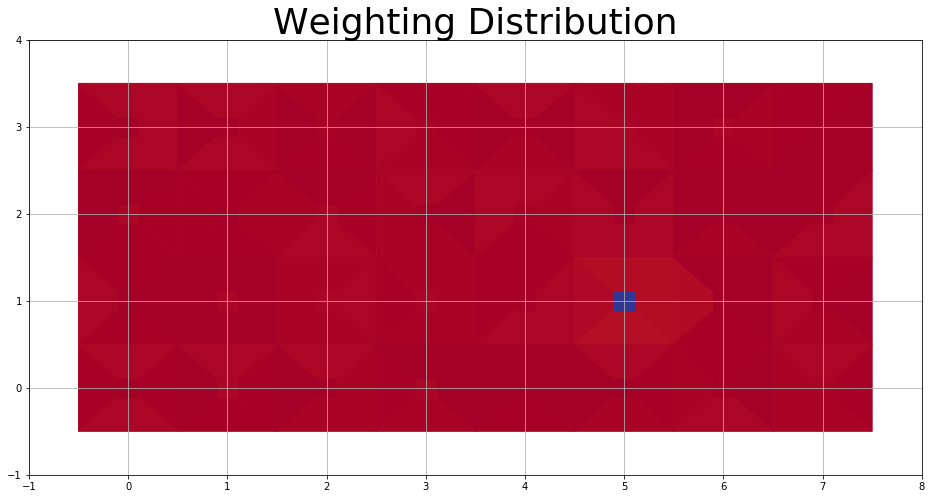

In [11]:
"""
    Setup Block # 4:
    SZ: edited Dec. 29, re-arranged
    This block contains setup for weights
"""

#@title Compute weights
if dataset_composition == 'optimal':
  """Distribution of the optimal policy (+ some noise)"""
  weights = sa_visitations
  weights = weights/ np.sum(weights)
elif dataset_composition == 'random':
  """A random disribution over states and actions""" 
  weights = np.random.uniform(size=env.num_states * env.num_actions)
  weights = np.reshape(weights, (env.num_states, env.num_actions))
  weights = weights/ np.sum(weights)
elif dataset_composition == 'random+optimal':
  """Mixture of random and optimal policies"""
  weights = sa_visitations / np.sum(sa_visitations)
  weights_rand = np.random.uniform(size=env.num_states * env.num_actions)
  weights_rand = np.reshape(weights_rand, (env.num_states, env.num_actions)) / np.sum(weights_rand)
  weights = (weights_rand + weights)/2.0
elif dataset_composition == 'mixed_limited':
  weights = sa_visitations / np.sum(sa_visitations)
  weights_rand = np.random.uniform(size=env.num_states * env.num_actions)
  weights_rand = np.reshape(weights_rand, (env.num_states, env.num_actions)) / np.sum(weights_rand)
  
  w = env.gs.width
  h = env.gs.height
  for x, y in itertools.product(range(w), range(h)):
    state_idx = env.gs.xy_to_idx((x, y))
    weights[state_idx] = weights_rand[state_idx] if valid_fn(x,y) else (weights_rand[state_idx] + weights[state_idx])/2
  weights = weights/np.sum(weights)
elif dataset_composition == 'mixed_limited_skewed':
  skew_weight = 10
  weights = sa_visitations / np.sum(sa_visitations)
  weights_rand = np.random.uniform(size=(env.num_states, env.num_actions))
  weights_rand[:,3] *= skew_weight
  weights_rand = weights_rand/np.sum(weights_rand.flatten())
  
  w = env.gs.width
  h = env.gs.height
  for x, y in itertools.product(range(w), range(h)):
    state_idx = env.gs.xy_to_idx((x, y))
    weights[state_idx] = weights_rand[state_idx] if valid_fn(x,y) else weights[state_idx]
  weights = weights/np.sum(weights)
elif dataset_composition == 'mixed':
  """Mixture of policies corresponding to random Q-values"""
  num_policies_mix = 4
  weights = np.zeros_like(sa_visitations)
  for idx in range(num_policies_mix):
    rand_q_vals_idx = np.random.uniform(low=0.0, high=10.0, size=(env.num_states, env.num_actions))
    policy_idx = compute_policy_deterministic(rand_q_vals_idx, eps_greedy=0.1)
    sa_visitations_idx = compute_visitation(env, policy_idx)
    weights = weights + sa_visitations_idx
  weights = weights / np.sum(weights)

# @title Generate dataset
weighting_only=False
if not weighting_only:
  weights_flatten = np.reshape(weights, -1)
  weights_flatten = weights_flatten/ np.sum(weights_flatten)
  dataset = np.random.choice(
      np.arange(env.num_states * env.num_actions),
      size=dataset_size, replace=True, p=weights_flatten
  )
  training_sa_pairs = [(int(val//env.num_actions), val % env.num_actions) for val in dataset]

  # Now sample (s', r) values for training as well
  training_dataset = []
  training_data_dist = np.zeros((env.num_states, env.num_actions))
  for idx in range(len(training_sa_pairs)):
    s, a = training_sa_pairs[idx]
    prob_s_prime = env._transition_matrix[s, a]
    s_prime = np.random.choice(np.arange(env.num_states), p=prob_s_prime)
    r = env.reward(s, a, s_prime)
    training_dataset.append((s, a, r, s_prime))
    training_data_dist[s, a] += 1.0
else:
  # Using only weighting style dataset
  training_dataset = None
  training_data_dist = None

#@title Visualize dataset or weights
plot_sa_values(env, training_data_dist, title='Dataset composition')
plot_sa_values(env, weights, title='Weighting Distribution')

True
 === computing mc returns from sampled data === 


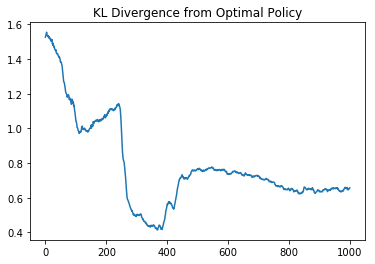

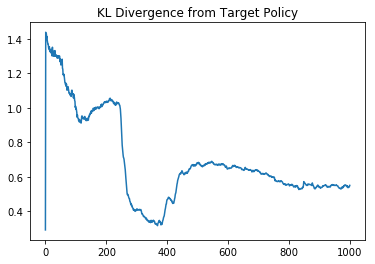

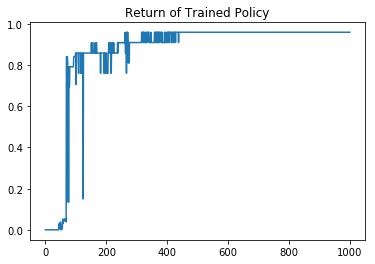

FQE_return_sampled: 0.983
 === running CQL from sampled data + MC bounds from sampled data === 


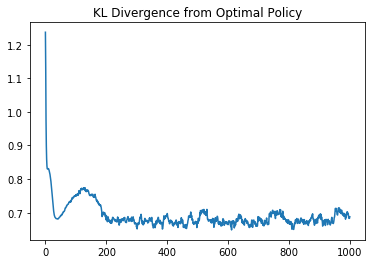

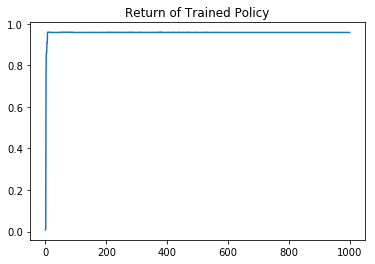

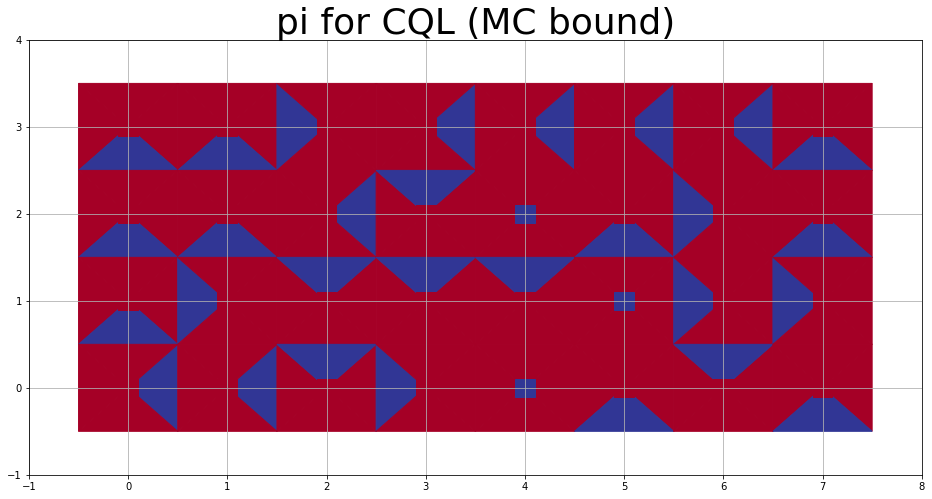

 === computing mc returns from sampled data === 


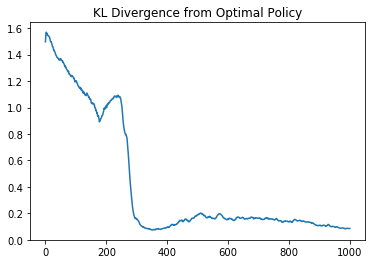

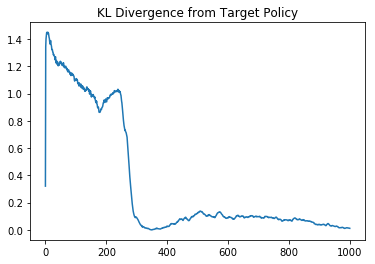

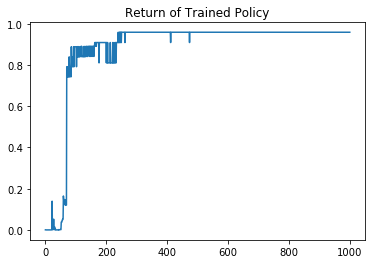

FQE_return_sampled: 0.983
 === running CQL from sampled data + MC bounds from sampled data === 


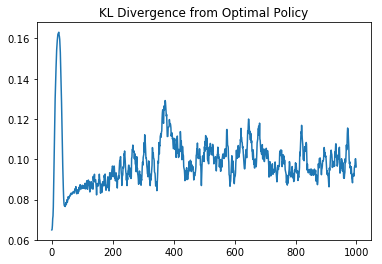

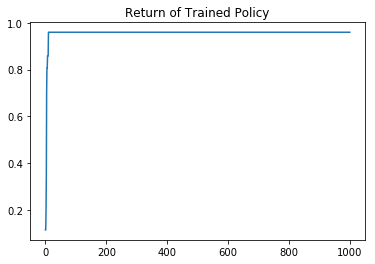

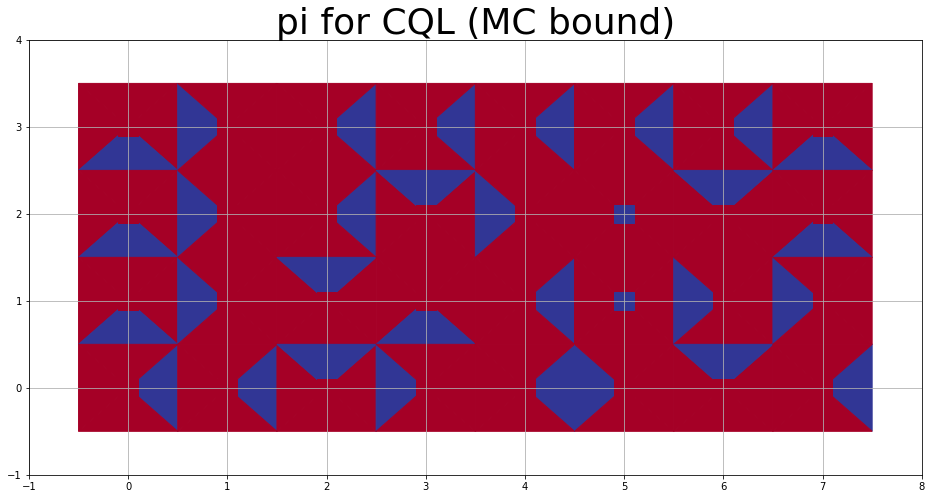

In [12]:
import numpy as np
### Basic params for dataset 
weighting_only = True #@param {type: "boolean"}
dataset_composition = 'random+optimal' #@param ["optimal", "random", "random+optimal", "mixed", 'mixed_limited', 'mixed_limited_skewed']
env_type = 'smooth' #@param ["smooth", "random", "onehot"]


### Total number of independent run
num_seed = 1

### Length of x axis (number of different samples to be tested)
num_resolution = 2
dataset_scale = 3000

### Setting CQL params
cql_alpha_val = 0.1 # @param {type:"slider", min:0.0, max:10.0, step:0.1}
transform_type = 7 # @param
const_transform = 1 # @param

print (weighting_only)


### Initializing two arrays for storing the final values
vanilla_cql_return = np.zeros(num_resolution)
mc_sampled_cql_return = np.zeros(num_resolution)
mc_true_cql_return = np.zeros(num_resolution)

for num in range(num_seed):
  for res in range(num_resolution):
    
    ### Generating Dataset
    dataset_size = (res+1) * dataset_scale
    
    #@title Compute weights
    if dataset_composition == 'optimal':
      """Distribution of the optimal policy (+ some noise)"""
      weights = sa_visitations
      weights = weights/ np.sum(weights)
    elif dataset_composition == 'random':
      """A random disribution over states and actions""" 
      weights = np.random.uniform(size=env.num_states * env.num_actions)
      weights = np.reshape(weights, (env.num_states, env.num_actions))
      weights = weights/ np.sum(weights)
    elif dataset_composition == 'random+optimal':
      """Mixture of random and optimal policies"""
      weights = sa_visitations / np.sum(sa_visitations)
      weights_rand = np.random.uniform(size=env.num_states * env.num_actions)
      weights_rand = np.reshape(weights_rand, (env.num_states, env.num_actions)) / np.sum(weights_rand)
      weights = (weights_rand + weights)/2.0
    elif dataset_composition == 'mixed_limited':
      weights = sa_visitations / np.sum(sa_visitations)
      weights_rand = np.random.uniform(size=env.num_states * env.num_actions)
      weights_rand = np.reshape(weights_rand, (env.num_states, env.num_actions)) / np.sum(weights_rand)

      w = env.gs.width
      h = env.gs.height
      for x, y in itertools.product(range(w), range(h)):
        state_idx = env.gs.xy_to_idx((x, y))
        weights[state_idx] = weights_rand[state_idx] if valid_fn(x,y) else (weights_rand[state_idx] + weights[state_idx])/2
      weights = weights/np.sum(weights)
    elif dataset_composition == 'mixed_limited_skewed':
      skew_weight = 10
      weights = sa_visitations / np.sum(sa_visitations)
      weights_rand = np.random.uniform(size=(env.num_states, env.num_actions))
      weights_rand[:,3] *= skew_weight
      weights_rand = weights_rand/np.sum(weights_rand.flatten())

      w = env.gs.width
      h = env.gs.height
      for x, y in itertools.product(range(w), range(h)):
        state_idx = env.gs.xy_to_idx((x, y))
        weights[state_idx] = weights_rand[state_idx] if valid_fn(x,y) else weights[state_idx]
      weights = weights/np.sum(weights)
    elif dataset_composition == 'mixed':
      """Mixture of policies corresponding to random Q-values"""
      num_policies_mix = 4
      weights = np.zeros_like(sa_visitations)
      for idx in range(num_policies_mix):
        rand_q_vals_idx = np.random.uniform(low=0.0, high=10.0, size=(env.num_states, env.num_actions))
        policy_idx = compute_policy_deterministic(rand_q_vals_idx, eps_greedy=0.1)
        sa_visitations_idx = compute_visitation(env, policy_idx)
        weights = weights + sa_visitations_idx
      weights = weights / np.sum(weights)

    # @title Generate dataset
    weighting_only=False
    if not weighting_only:
      weights_flatten = np.reshape(weights, -1)
      weights_flatten = weights_flatten/ np.sum(weights_flatten)
      dataset = np.random.choice(
          np.arange(env.num_states * env.num_actions),
          size=dataset_size, replace=True, p=weights_flatten
      )
      training_sa_pairs = [(int(val//env.num_actions), val % env.num_actions) for val in dataset]

      # Now sample (s', r) values for training as well
      training_dataset = []
      training_data_dist = np.zeros((env.num_states, env.num_actions))
      for idx in range(len(training_sa_pairs)):
        s, a = training_sa_pairs[idx]
        prob_s_prime = env._transition_matrix[s, a]
        s_prime = np.random.choice(np.arange(env.num_states), p=prob_s_prime)
        r = env.reward(s, a, s_prime)
        training_dataset.append((s, a, r, s_prime))
        training_data_dist[s, a] += 1.0
    else:
      # Using only weighting style dataset
      training_dataset = None
      training_data_dist = None
    
    """
        Compute Block # 1
    """
    # Use a tabular or feedforward NN approximator
    network = FCNetwork(env, layers=[20, 20])
    #network = TabularNetwork(env)

    # Run Q-iteration
    print(" === computing mc returns from sampled data === ")
    q_mc_returns_sampled = fitted_q_evaluation(
      env, 
      network,
      num_itrs=num_itrs, 
      discount=discount, 
      weights=weights, 
      render=False,
      sampled=True,
      training_dataset=training_dataset, 
      optimal_policy=optimal_policy
    )

    policy = compute_policy_deterministic(q_mc_returns_sampled, eps_greedy=0) 
    FQE_return_sampled = compute_return(env, policy, T=num_itrs)
    print(f"FQE_return_sampled: {FQE_return_sampled}")

    if False:
      print(" === computing mc returns from true transition === ")
      q_mc_returns_true = fitted_q_evaluation(
        env, 
        network,
        num_itrs=num_itrs, 
        discount=discount, 
        weights=weights, 
        render=False,
        optimal_policy=optimal_policy
      )

      policy = compute_policy_deterministic(q_mc_returns_true, eps_greedy=0)
      FQE_returns_true = compute_return(env, policy, T=num_itrs)
      print(f"FQE_returns_true: {FQE_returns_true}")

    """
        Compute Block # 2
    """

    ### Second: Run regular fitted CQL with finite data
    
    ### Run CQL without MC_bound

    if False:
      print(" === running vanilla CQL from sampled data === ")

      q_values = conservative_q_iteration(
        env, 
        network,
        num_itrs=num_itrs, 
        discount=discount, 
        cql_alpha=cql_alpha_val, 
        weights=weights, 
        render=False,
        sampled=True,
        training_dataset=training_dataset,
        transform_type=transform_type, 
        const_transform=const_transform,
        optimal_policy=optimal_policy
      )

      #@title Compute visitations of the learned policy
      policy = compute_policy_deterministic(q_values, eps_greedy=0)
      policy_sa_visitations = compute_visitation(env, policy, T=num_itrs)
      plot_sa_values(env, policy, title='pi for CQL (no MC bound)')

      cql_return = compute_return(env, policy, T=num_itrs)
      vanilla_cql_return[res] += cql_return

    ### Run CQL with MC_bound + sampled MC value

    print(" === running CQL from sampled data + MC bounds from sampled data === ")

    q_values = conservative_q_iteration(env, network,
                                        num_itrs=num_itrs, discount=discount, cql_alpha=cql_alpha_val, 
                                        weights=weights, render=False,
                                        sampled=not(weighting_only),
                                        training_dataset=training_dataset, 
                                        transform_type=transform_type, const_transform=const_transform,
                                        optimal_policy=optimal_policy, 
                                        mc_returns=q_mc_returns_sampled)

    #@title Compute visitations of the learned policy
    policy = compute_policy_deterministic(q_values, eps_greedy=0)
    policy_sa_visitations = compute_visitation(env, policy, T=num_itrs)
    plot_sa_values(env, policy, title='pi for CQL (MC bound)')

    # plot_sa_values(env, policy_sa_visitations, title='Q-hat Visitation')
    cql_return_mc_sampled = compute_return(env, policy, T=num_itrs)
    mc_sampled_cql_return[res] += cql_return_mc_sampled

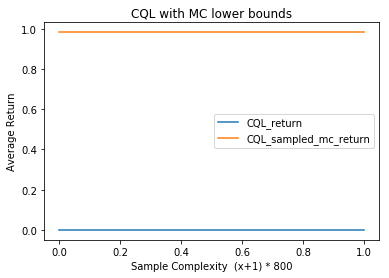

In [13]:
#Plot a line graph
plt.plot(vanilla_cql_return/num_seed, label='CQL_return')
plt.plot(mc_sampled_cql_return/num_seed, label='CQL_sampled_mc_return')

# Add labels and title
plt.title("CQL with MC lower bounds")
plt.xlabel("Sample Complexity  (x+1) * 800")
plt.ylabel("Average Return")
 
plt.legend()
plt.show()

In [14]:
print(q_mc_returns_sampled.shape)

(32, 5)
